In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 500)
import datetime

def get_tick(df: pd.DataFrame, timestamp: int = None):
    """Function gets tick for each expiration and strike
    from closest timestamp from given. If timestamp is None, it takes last one."""
    if timestamp:
        data = df[df["timestamp"] <= timestamp].copy()
        # only not expired on curret tick
        data = data[data["expiration"] > timestamp].copy()
    else:
        data = df.copy()
        # only not expired on max available tick
        data = data[data["expiration"] > data["timestamp"].max()].copy()
    # tau is time before expiration in years
    data["tau"] = (data.expiration - data.timestamp) / 1e6 / 3600 / 24 / 365

    data_grouped = data.loc[
        data.groupby(["type", "expiration", "strike_price"])["timestamp"].idxmax()
    ]

    data_grouped = data_grouped[data_grouped["tau"] > 0.0]
    # We need Only out of the money to calibrate
    data_grouped = data_grouped[
        (
            (data_grouped["type"] == "call")
            & (data_grouped["underlying_price"] <= data_grouped["strike_price"])
        )
        | (
            (data_grouped["type"] == "put")
            & (data_grouped["underlying_price"] >= data_grouped["strike_price"])
        )
    ]
    data_grouped["mark_price_usd"] = (
        data_grouped["mark_price"] * data_grouped["underlying_price"]
    )
    data_grouped = data_grouped[data_grouped["strike_price"] <= 10_000]
    # print(data_grouped)
    return data_grouped

# Попробуем найти зависимость best_bid - best_ask ~ F(f, S)

In [6]:
df = pd.read_csv(f"../datasets/deribit_options_chain_2022-12-01_OPTIONS.csv")
data = df.copy()
data = data[data["symbol"].str.startswith("ETH")]

In [54]:
prepr = get_tick(data, 1669895389325000)
exp = prepr[prepr["expiration"] == 1680249600000000][["strike_price", "bid_iv", 
                                                      "ask_iv", "mark_iv", "underlying_price", "type"]]

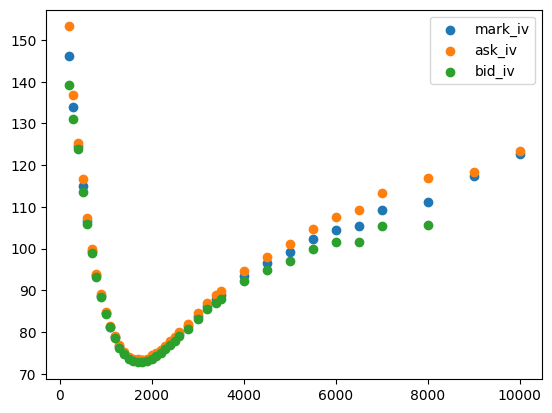

In [55]:
plt.scatter(exp["strike_price"], exp["mark_iv"], label = "mark_iv")
plt.scatter(exp["strike_price"], exp["ask_iv"], label = "ask_iv")
plt.scatter(exp["strike_price"], exp["bid_iv"], label = "bid_iv")
plt.legend()

Видо, что чем больше разница между strike и forward, тем больше разница ask_iv - mark_iv и mark_iv - bid_iv. Посмотрим, как они отличаются

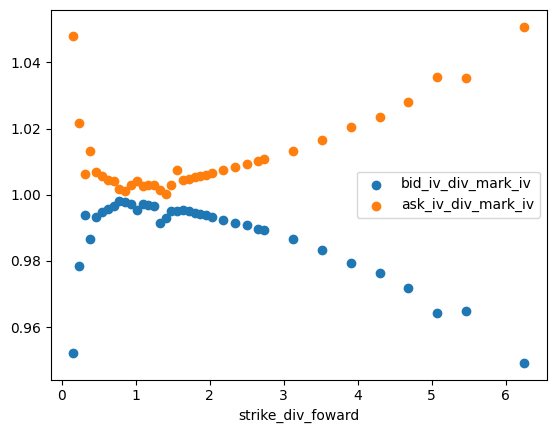

In [57]:
exp["strike_div_forward"] = exp["strike_price"]/exp["underlying_price"]
exp["bid_div_mark"] = exp["bid_iv"]/exp["mark_iv"]
exp["ask_div_mark"] = exp["ask_iv"]/exp["mark_iv"]
exp = exp[(exp["ask_div_mark"] <= 4) & (exp["bid_div_mark"] <= 4)]

plt.scatter(exp["strike_div_forward"],
            exp["bid_div_mark"], label = "bid_iv_div_mark_iv")
plt.scatter(exp["strike_div_forward"],
            exp["ask_div_mark"], label = "ask_iv_div_mark_iv")

plt.xlabel("strike_div_foward")
plt.legend()

In [51]:
# теперь ясна зависимость. Можно захардкодить и переиспользовать, когда в данных нет bid_iv, ask_iv. 
exp

,strike_price,bid_iv,ask_iv,mark_iv,underlying_price,type,strike_div_forward,bid_div_mark,ask_div_mark
10422832,1300,76.22,76.89,76.57,1279.95,call,1.015665,0.995429,1.004179
10421850,1400,74.78,75.21,75.00,1279.94,call,1.093801,0.997067,1.002800
10422835,1500,73.66,74.10,73.89,1279.95,call,1.171921,0.996887,1.002842
10421929,1600,73.11,73.57,73.35,1279.94,call,1.250059,0.996728,1.002999
10422831,1700,72.73,73.46,73.35,1279.95,call,1.328177,0.991547,1.001500
10422825,1800,72.84,73.36,73.35,1279.95,call,1.406305,0.993047,1.000136
10421787,1900,72.99,73.56,73.35,1279.94,call,1.484445,0.995092,1.002863
10421927,2000,73.48,74.41,73.85,1279.94,call,1.562573,0.994990,1.007583
10421807,2100,74.30,74.99,74.65,1279.94,call,1.640702,0.995311,1.004555
10421932,2200,75.04,75.78,75.42,1279.94,call,1.718831,0.994962,1.004773
